In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor
import optuna

CPU times: user 1.93 s, sys: 987 ms, total: 2.91 s
Wall time: 2.16 s


In [2]:
df = pd.read_csv("train.csv")

In [3]:
dep_var = "num_sold"

df = add_datepart(df, "date")

In [4]:
df.head()

,row_id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
1,1,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
2,2,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
3,3,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
4,4,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09


In [5]:
cont, cat = cont_cat_split(df, 9000, dep_var)

In [6]:
cont

['row_id', 'Elapsed']

In [7]:
cat

['country',
 'store',
 'product',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [8]:
cont.remove('row_id')

In [9]:
cond = ((df.Year == 2018) & (df.Month > 6))
train_idx = np.where(~cond)[0]
valid_idx = np.where(cond)[0]

In [11]:
splits = (list(train_idx), list(valid_idx))

In [12]:
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [13]:
len(valid_idx)

3312

In [15]:
def SMAPE(preds, targs):
    denominator = (targs + np.abs(preds)) / 200.0
    diff = np.abs(preds - targs) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [16]:
smape = AccumMetric(SMAPE, to_np = True,)

In [17]:
dls = to.dataloaders(1024, device = "cuda")

In [18]:
dls.show_batch()

,country,store,product,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,num_sold
0,Finland,KaggleMart,Kaggle Sticker,2016,8,33,16,1,229,False,False,False,False,False,False,1.471306e+09,87.0
1,Finland,KaggleRama,Kaggle Sticker,2015,10,44,30,4,303,False,False,False,False,False,False,1.446163e+09,144.0
2,Finland,KaggleMart,Kaggle Sticker,2016,7,28,14,3,196,False,False,False,False,False,False,1.468454e+09,87.0
3,Finland,KaggleRama,Kaggle Sticker,2015,7,27,3,4,184,False,False,False,False,False,False,1.435882e+09,153.0
4,Norway,KaggleMart,Kaggle Hat,2017,8,33,17,3,229,False,False,False,False,False,False,1.502928e+09,475.0
5,Finland,KaggleRama,Kaggle Sticker,2018,2,5,4,6,35,False,False,False,False,False,False,1.517702e+09,222.0
6,Norway,KaggleMart,Kaggle Hat,2015,3,13,26,3,85,False,False,False,False,False,False,1.427328e+09,635.0
7,Norway,KaggleMart,Kaggle Hat,2015,10,43,22,3,295,False,False,False,False,False,False,1.445472e+09,390.0
8,Sweden,KaggleMart,Kaggle Sticker,2016,9,38,25,6,269,False,False,False,False,False,False,1.474762e+09,123.0
9,Sweden,KaggleRama,Kaggle Hat,2016,6,25,25,5,177,False,False,False,False,False,False,1.466813e+09,822.0


In [21]:
dls.train.y.min(), dls.train.y.max()

(70, 2807)

In [22]:
learn = tabular_learner(dls, y_range = (69, 2808), n_out = 1, layers = [500, 250], metrics = smape)

CPU times: user 4.33 s, sys: 1.54 s, total: 5.87 s
Wall time: 6.09 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.001737800776027143)

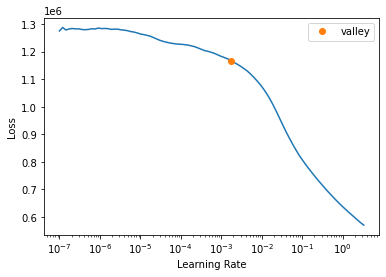

In [23]:
%%time
learn.lr_find()

In [25]:
learn.fit_one_cycle(50,)

epoch,train_loss,valid_loss,SMAPE,time
0,352.835663,7021.931152,11.475266,00:00
1,361.312744,6882.247559,11.003491,00:00
2,371.969696,5235.596680,9.454691,00:00
3,401.901794,5643.510742,10.014583,00:00
4,427.477417,8160.035156,13.184781,00:00
5,458.374969,7437.750000,11.913160,00:00
6,528.026917,5152.188477,9.000759,00:00
7,537.219299,5991.500488,10.924462,00:00
8,532.098938,9807.347656,15.771046,00:00
9,580.449158,12645.906250,18.401289,00:00


In [33]:
pred_y , _ = learn.get_preds()

In [34]:
len(pred_y)

3312

In [37]:
valid_y = dls.valid.y

In [39]:
### using gdp dataset

In [40]:
df.head()

,row_id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
1,1,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
2,2,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
3,3,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
4,4,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09


In [44]:
gdp = pd.read_csv("GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv")

In [45]:
gdp.head()

,year,Finland,Norway,Sweden
0,2015,42802,74356,51545
1,2016,43814,70461,51965
2,2017,46412,75497,53792
3,2018,50038,82268,54589
4,2019,48712,75826,51687


In [48]:
gdp = gdp.melt(id_vars = 'year', value_vars = ['Finland', 'Norway', 'Sweden'], var_name = 'country', value_name = 'gdp')

In [49]:
gdp

,year,country,gdp
0,2015,Finland,42802
1,2016,Finland,43814
2,2017,Finland,46412
3,2018,Finland,50038
4,2019,Finland,48712
5,2015,Norway,74356
6,2016,Norway,70461
7,2017,Norway,75497
8,2018,Norway,82268
9,2019,Norway,75826


In [51]:
df = df.rename(columns = {"Year" : "year"})

In [53]:
df = df.merge(gdp, on = ["year", "country"], how = 'left')

In [54]:
df

,row_id,country,store,product,num_sold,year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,gdp
0,0,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,42802
1,1,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,42802
2,2,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,42802
3,3,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,42802
4,4,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,42802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,26293,Sweden,KaggleMart,Kaggle Hat,823,2018,12,1,31,0,365,True,False,True,False,True,False,1.546214e+09,54589
26294,26294,Sweden,KaggleMart,Kaggle Sticker,250,2018,12,1,31,0,365,True,False,True,False,True,False,1.546214e+09,54589
26295,26295,Sweden,KaggleRama,Kaggle Mug,1004,2018,12,1,31,0,365,True,False,True,False,True,False,1.546214e+09,54589
26296,26296,Sweden,KaggleRama,Kaggle Hat,1441,2018,12,1,31,0,365,True,False,True,False,True,False,1.546214e+09,54589


In [55]:
cont, cat = cont_cat_split(df, 9000, dep_var)

In [56]:
cont

['row_id', 'Elapsed']

In [57]:
cont.remove('row_id')

In [58]:
cat

['country',
 'store',
 'product',
 'year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'gdp']

In [77]:
to = TabularPandas(df, procs, cat, cont, dep_var, splits = splits, y_block = RegressionBlock)

In [78]:
dls = to.dataloaders(1024, device = "cuda")

In [79]:
learn = tabular_learner(dls, n_out = 1, metrics = smape, layers = [500, 250])

In [80]:
%%time
learn.fit_one_cycle(50, 1e-1, cbs = [SaveModelCallback(monitor = 'SMAPE', comp = np.less)])

epoch,train_loss,valid_loss,SMAPE,time
0,215205.218750,214857.062500,198.522263,00:00
1,200807.093750,190617.546875,188.274643,00:00
2,167640.265625,362323.437500,191.947861,00:00
3,116550.546875,66882.257812,114.392944,00:00
4,72046.515625,8208.053711,12.704217,00:00
5,45343.070312,10424.415039,42.981911,00:00
6,28901.292969,3905.890137,15.123007,00:00
7,18739.384766,4285.451172,9.558141,00:00
8,12432.823242,9761.135742,51.004173,00:00
9,8556.306641,8048.714844,41.149540,00:00


Better model found at epoch 0 with SMAPE value: 198.5222625732422.
Better model found at epoch 1 with SMAPE value: 188.27464294433594.
Better model found at epoch 3 with SMAPE value: 114.3929443359375.
Better model found at epoch 4 with SMAPE value: 12.704216957092285.
Better model found at epoch 7 with SMAPE value: 9.558140754699707.
Better model found at epoch 12 with SMAPE value: 6.049903869628906.
CPU times: user 16.4 s, sys: 299 ms, total: 16.7 s
Wall time: 16.4 s


In [84]:
embs = [param for param in learn.model.embeds.parameters()]

In [85]:
len(embs)

16

In [86]:
emb_dict = {}
cats = list(to.cat_names)
print (len(cat))
for i,j in zip(cats, embs) :
    j = j.to(device = "cpu")
    j = j.detach().numpy()
    emb_dict[i] = j

16


In [88]:
cat = to.procs.categorify
country_cat = cat['country']
country_cat

['#na#', 'Finland', 'Norway', 'Sweden']

In [89]:
country_map = {country_cat[i] : emb_dict['country'][i] for i in range(len(country_cat))}

In [90]:
cat = to.procs.categorify
product_cat = cat['product']
print (product_cat)
product_map = {product_cat[i] : emb_dict['product'][i] for i in range(len(product_cat))}

['#na#', 'Kaggle Hat', 'Kaggle Mug', 'Kaggle Sticker']


In [91]:
product_map

{'#na#': array([0.00683236, 0.00508833, 0.00599859], dtype=float32),
 'Kaggle Hat': array([0.7640513 , 0.65729266, 0.70615995], dtype=float32),
 'Kaggle Mug': array([-0.3455286 , -0.19269109, -0.32919452], dtype=float32),
 'Kaggle Sticker': array([-1.2783401, -1.089227 , -1.0598474], dtype=float32)}

In [92]:
country_map

{'#na#': array([0.00563019, 0.01524144, 0.00570783], dtype=float32),
 'Finland': array([-0.88503706,  0.88509035, -0.8669394 ], dtype=float32),
 'Norway': array([ 0.3868954 , -0.39995733,  0.27259365], dtype=float32),
 'Sweden': array([-0.46402732,  0.42754886, -0.5154188 ], dtype=float32)}

In [93]:
cat = to.procs.categorify
store_cat = cat['store']
print (store_cat)
store_map = {store_cat[i] : emb_dict['store'][i] for i in range(len(store_cat))}

['#na#', 'KaggleMart', 'KaggleRama']


In [94]:
store_map

{'#na#': array([ 0.0085143 , -0.00482995, -0.00315291], dtype=float32),
 'KaggleMart': array([ 0.9677503, -0.9291847,  1.1173302], dtype=float32),
 'KaggleRama': array([-0.3002731 ,  0.35864115, -0.29612175], dtype=float32)}

In [95]:
cat = to.procs.categorify
month_cat = cat['Month']
print (month_cat)
month_map = {month_cat[i] : emb_dict['Month'][i] for i in range(len(month_cat))}

['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [96]:
import pickle

with open("embs/product_map.pkl", "wb") as f:
    pickle.dump(product_map, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("embs/country_map.pkl", "wb") as f:
    pickle.dump(country_map, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("embs/store_map.pkl", "wb") as f:
    pickle.dump(store_map, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("embs/month_map.pkl", "wb") as f:
    pickle.dump(month_map, f, protocol=pickle.HIGHEST_PROTOCOL)

In [97]:
learn.export()